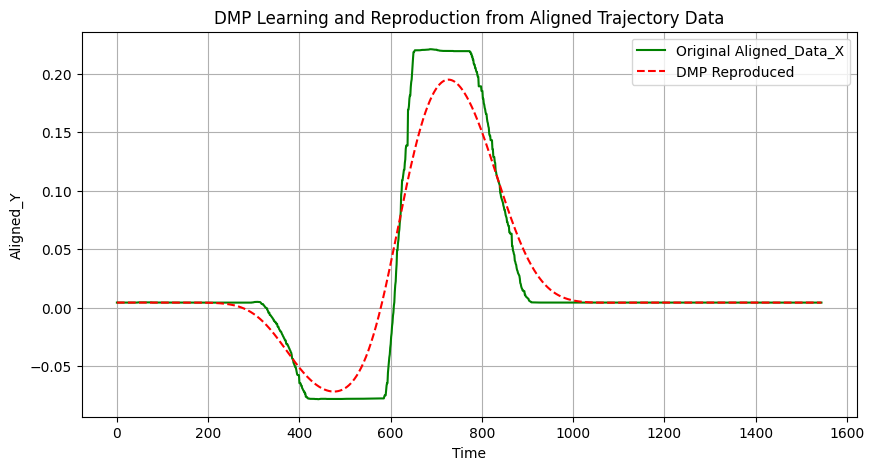

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from cs import CanonicalSystem

# Load trajectory data from CSV
Data1 = pd.read_csv("aligned_trajectory_data_y.csv")
y_demo = Data1[["Aligned_Y"]].values  # Extract the Aligned_Y column

y_demo = y_demo.T if y_demo.ndim == 1 else y_demo.T  
data_len = y_demo.shape[1]  


# Define DMP class
class dmp_discrete():
    def __init__(self, n_dmps=1, n_bfs=100, dt=0.01, alpha_y=None, beta_y=None, **kwargs):
        self.n_dmps = n_dmps
        self.n_bfs = n_bfs
        self.dt = dt

        self.y0 = np.zeros(n_dmps)
        self.goal = np.ones(n_dmps)

        alpha_y_tmp = 60 if alpha_y is None else alpha_y
        beta_y_tmp = alpha_y_tmp / 4.0 if beta_y is None else beta_y
        self.alpha_y = np.ones(n_dmps) * alpha_y_tmp
        self.beta_y = np.ones(n_dmps) * beta_y_tmp
        self.tau = 1.0

        self.w = np.zeros((n_dmps, n_bfs))  # Weights for forcing term
        self.psi_centers = np.zeros(self.n_bfs)
        self.psi_h = np.zeros(self.n_bfs)

        self.cs = CanonicalSystem(dt=self.dt, **kwargs)
        self.timesteps = round(self.cs.run_time / self.dt)

        self.generate_centers()
        self.h = np.ones(self.n_bfs) * self.n_bfs**1.5 / self.psi_centers / self.cs.alpha_x
        self.reset_state()

    def reset_state(self):
        self.y = self.y0.copy()
        self.dy = np.zeros(self.n_dmps)
        self.ddy = np.zeros(self.n_dmps)
        self.cs.reset_state()

    def generate_centers(self):
        t_centers = np.linspace(0, self.cs.run_time, self.n_bfs)
        x_track = self.cs.run()
        t_track = np.linspace(0, self.cs.run_time, self.cs.timesteps)

        for n in range(len(t_centers)):
            for i, t in enumerate(t_track):
                if abs(t_centers[n] - t) <= self.cs.dt:
                    self.psi_centers[n] = x_track[i]
        
        return self.psi_centers

    def generate_psi(self, x):
        if isinstance(x, np.ndarray):
            x = x[:, None]
        self.psi = np.exp(-self.h * (x - self.psi_centers)**2)
        return self.psi

    def generate_weights(self, f_target):
        x_track = self.cs.run()
        psi_track = self.generate_psi(x_track)

        for d in range(self.n_dmps):
            delta = 1.0
            for b in range(self.n_bfs):
                numer = np.sum(x_track * psi_track[:, b] * f_target[:, d])
                denom = np.sum(x_track**2 * psi_track[:, b])
                self.w[d, b] = numer / denom if abs(delta) > 1e-6 else 0
                
        self.w = np.nan_to_num(self.w)
        return self.w

    def learning(self, y_demo, plot=False):
        if y_demo.ndim == 1:
            y_demo = y_demo.reshape(1, len(y_demo))

        self.y0 = y_demo[:, 0].copy()
        self.goal = y_demo[:, -1].copy()
        self.y_demo = y_demo.copy()

        x = np.linspace(0, self.cs.run_time, y_demo.shape[1])
        y = np.zeros((self.n_dmps, self.timesteps))
        for d in range(self.n_dmps):
            y_tmp = interp1d(x, y_demo[d])
            for t in range(self.timesteps):
                y[d, t] = y_tmp(t * self.dt)

        dy_demo = np.gradient(y, axis=1) / self.dt
        ddy_demo = np.gradient(dy_demo, axis=1) / self.dt

        x_track = self.cs.run()
        f_target = np.zeros((y_demo.shape[1], self.n_dmps))
        for d in range(self.n_dmps):
            k = self.alpha_y[d]
            f_target[:, d] = (ddy_demo[d] - self.alpha_y[d] * (self.beta_y[d] * (self.goal[d] - y_demo[d]) - dy_demo[d])) / k + x_track * (self.goal[d] - self.y0[d])
        
        self.generate_weights(f_target)
        self.reset_state()

    def reproduce(self, tau=None, initial=None, goal=None):
        timesteps = self.timesteps if tau is None else round(self.timesteps / tau)
        if initial is not None:
            self.y0 = initial
        if goal is not None:
            self.goal = goal
        self.reset_state()

        y_reproduce = np.zeros((timesteps, self.n_dmps))
        for t in range(timesteps):
            y_reproduce[t], _, _ = self.step(tau=tau)
        return y_reproduce

    def step(self, tau=None):
        tau = self.tau if tau is None else tau
        x = self.cs.step_discrete(tau)
        psi = self.generate_psi(x)

        for d in range(self.n_dmps):
            k = self.alpha_y[d]
            f = k * (np.dot(psi, self.w[d]) * x / np.sum(psi)) - k * (self.goal[d] - self.y0[d]) * x
            self.ddy[d] = self.alpha_y[d] * (self.beta_y[d] * (self.goal[d] - self.y[d]) - self.dy[d]) + f
            self.dy[d] += tau * self.ddy[d] * self.dt
            self.y[d] += tau * self.dy[d] * self.dt
        
        return self.y, self.dy, self.ddy

#%% Test with the new trajectory data
if __name__ == "__main__":
    dmp = dmp_discrete(n_dmps=y_demo.shape[0], n_bfs=100, dt=1.0/data_len)
    dmp.learning(y_demo, plot=False)

    # Reproduce learned trajectory
    y_reproduce = dmp.reproduce()

    # Set new initial and goal positions for variation
    y_reproduce_2 = dmp.reproduce(tau=1, initial=[y_demo[0, 0]], goal=[y_demo[0, -1]])

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(y_demo[0, :], 'g', label='Original Aligned_Data_X')
    plt.plot(y_reproduce[:, 0], 'r--', label='DMP Reproduced')
    #plt.plot(y_reproduce_2[:, 0], 'b-.', label='DMP Adjusted')
    plt.legend()
    plt.grid()
    plt.xlabel('Time')
    plt.ylabel('Aligned_Y')
    plt.title('DMP Learning and Reproduction from Aligned Trajectory Data')
    plt.show()